# Competitor Price Forecasting - LightGBM Ensemble Model
# Retailz Pricing Analysis and Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Model libraries
import lightgbm as lgb
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.pipeline import Pipeline
import joblib

# Database
import sqlite3

print("All libraries imported successfully!")

All libraries imported successfully!


# ================================
# CELL 2: Data Loading and Initial Exploration
# ================================

In [2]:
def load_datasets():
    """Load all datasets with proper error handling"""
    try:
        # Load main datasets
        prices_df = pd.read_csv('data/product_prices_leaflets.csv')
        structures_df = pd.read_csv('data/product_structures_sales.csv')
        campaigns_df = pd.read_csv('data/chain_campaigns.csv')
        
        # Load Portugal campaigns (optional)
        try:
            portugal_campaigns_df = pd.read_csv('data/portugal_retail_campaigns_2025_updated.csv')
        except:
            portugal_campaigns_df = None
            print("Portugal campaigns file not found - creating dummy data")
        
        print("✅ Datasets loaded successfully!")
        print(f"Prices dataset shape: {prices_df.shape}")
        print(f"Structures dataset shape: {structures_df.shape}")
        print(f"Campaigns dataset shape: {campaigns_df.shape}")
        
        return prices_df, structures_df, campaigns_df, portugal_campaigns_df
        
    except Exception as e:
        print(f"❌ Error loading datasets: {e}")
        return None, None, None, None

# Load datasets
prices_df, structures_df, campaigns_df, portugal_campaigns_df = load_datasets()

# Display basic info
if prices_df is not None:
    print("\n=== PRICE DATASET INFO ===")
    print(prices_df.head())
    print(f"\nUnique competitors: {prices_df['competitor'].unique()}")
    print(f"Date range: {prices_df['time_key'].min()} to {prices_df['time_key'].max()}")

✅ Datasets loaded successfully!
Prices dataset shape: (3112140, 7)
Structures dataset shape: (1864594, 7)
Campaigns dataset shape: (99, 4)

=== PRICE DATASET INFO ===
    sku  time_key   competitor  pvp_was  discount  flag_promo leaflet
0  2056  20240312        chain    21.70    0.0000           0     NaN
1  4435  20230621        chain    18.92    0.2754           1  weekly
2  1951  20230303  competitorA    60.58    0.3524           1     NaN
3  2135  20240605        chain    55.37    0.2509           1  weekly
4  3949  20230529        chain    51.90    0.0000           0     NaN

Unique competitors: ['chain' 'competitorA' 'competitorB']
Date range: 20230103 to 20241028


# ================================
# CELL 3: Data Quality Assessment and Cleaning
# ================================

In [3]:
def assess_data_quality(prices_df, structures_df, campaigns_df):
    """Comprehensive data quality assessment"""
    
    print("=== DATA QUALITY ASSESSMENT ===\n")
    
    # Check for missing values
    print("Missing values in prices dataset:")
    print(prices_df.isnull().sum())
    print("\nMissing values in structures dataset:")
    print(structures_df.isnull().sum())
    print("\nMissing values in campaigns dataset:")
    print(campaigns_df.isnull().sum())
    
    # Check for negative values (errors)
    print(f"\nNegative discount values: {(prices_df['discount'] < 0).sum()}")
    print(f"Negative quantity values: {(structures_df['quantity'] < 0).sum()}")
    
    # Check duplicates
    print(f"\nDuplicates in prices: {prices_df.duplicated().sum()}")
    print(f"Duplicates in structures: {structures_df.duplicated().sum()}")
    
    # Date range validation
    print(f"\nPrice data date range: {prices_df['time_key'].min()} - {prices_df['time_key'].max()}")
    print(f"Structure data date range: {structures_df['time_key'].min()} - {structures_df['time_key'].max()}")

def clean_data(prices_df, structures_df):
    """Clean and preprocess the datasets"""
    
    print("=== DATA CLEANING ===\n")
    
    # Clean prices dataset
    prices_clean = prices_df.copy()
    
    # Remove negative discount values (errors)
    initial_rows = len(prices_clean)
    prices_clean = prices_clean[prices_clean['discount'] >= 0]
    print(f"Removed {initial_rows - len(prices_clean)} rows with negative discounts")
    
    # Clean structures dataset
    structures_clean = structures_df.copy()
    
    # Remove negative quantity values (errors)
    initial_rows = len(structures_clean)
    structures_clean = structures_clean[structures_clean['quantity'] >= 0]
    print(f"Removed {initial_rows - len(structures_clean)} rows with negative quantities")
    
    # Convert time_key to datetime
    prices_clean['date'] = pd.to_datetime(prices_clean['time_key'], format='%Y%m%d')
    structures_clean['date'] = pd.to_datetime(structures_clean['time_key'], format='%Y%m%d')
    
    # Calculate final price after discount
    prices_clean['final_price'] = prices_clean['pvp_was'] * (1 - prices_clean['discount'])
    
    print("✅ Data cleaning completed!")
    return prices_clean, structures_clean

# Assess and clean data
if prices_df is not None:
    assess_data_quality(prices_df, structures_df, campaigns_df)
    prices_clean, structures_clean = clean_data(prices_df, structures_df)

=== DATA QUALITY ASSESSMENT ===

Missing values in prices dataset:
sku                 0
time_key            0
competitor          0
pvp_was             0
discount            0
flag_promo          0
leaflet       2510555
dtype: int64

Missing values in structures dataset:
structure_level_4    0
structure_level_3    0
structure_level_2    0
structure_level_1    0
sku                  0
time_key             0
quantity             0
dtype: int64

Missing values in campaigns dataset:
competitor        0
start_date        0
end_date          0
chain_campaign    0
dtype: int64

Negative discount values: 40
Negative quantity values: 292

Duplicates in prices: 0
Duplicates in structures: 0

Price data date range: 20230103 - 20241028
Structure data date range: 20230103 - 20241028
=== DATA CLEANING ===

Removed 40 rows with negative discounts
Removed 292 rows with negative quantities
✅ Data cleaning completed!


# ================================
# CELL 4: Feature Engineering
# ================================

In [4]:
def create_campaign_features(campaigns_df):
    """Create campaign features from campaign data"""
    
    if campaigns_df is None:
        return pd.DataFrame()
    
    campaigns_processed = campaigns_df.copy()
    campaigns_processed['start_date'] = pd.to_datetime(campaigns_processed['start_date'])
    campaigns_processed['end_date'] = pd.to_datetime(campaigns_processed['end_date'])
    campaigns_processed['campaign_duration'] = (
        campaigns_processed['end_date'] - campaigns_processed['start_date']
    ).dt.days
    
    return campaigns_processed

def engineer_features(prices_clean, structures_clean, campaigns_processed):
    """Comprehensive feature engineering"""
    print("=== FEATURE ENGINEERING ===\n")
    
    # Merge prices with product structures
    merged_df = prices_clean.merge(
        structures_clean[['sku', 'time_key', 'structure_level_1', 'structure_level_2', 
                         'structure_level_3', 'structure_level_4', 'quantity']].drop_duplicates(),
        on=['sku', 'time_key'],
        how='left'
    )
    
    print(f"Merged dataset shape: {merged_df.shape}")
    
    # Sort by competitor, sku, and date for time series features
    merged_df = merged_df.sort_values(['competitor', 'sku', 'date'])
    
    # Create time-based features
    merged_df['year'] = merged_df['date'].dt.year
    merged_df['month'] = merged_df['date'].dt.month
    merged_df['day'] = merged_df['date'].dt.day
    merged_df['weekday'] = merged_df['date'].dt.weekday
    merged_df['quarter'] = merged_df['date'].dt.quarter
    merged_df['week_of_year'] = merged_df['date'].dt.isocalendar().week
    
    # Create lag features for prices
    for lag in [1, 7, 14, 30]:
        merged_df[f'price_lag_{lag}'] = merged_df.groupby(['competitor', 'sku'])['final_price'].shift(lag)
        merged_df[f'discount_lag_{lag}'] = merged_df.groupby(['competitor', 'sku'])['discount'].shift(lag)
    
    # Create rolling statistics
    for window in [7, 14, 30]:
        merged_df[f'price_rolling_mean_{window}'] = (
            merged_df.groupby(['competitor', 'sku'])['final_price']
            .transform(lambda x: x.rolling(window, min_periods=1).mean())
        )
        merged_df[f'price_rolling_std_{window}'] = (
            merged_df.groupby(['competitor', 'sku'])['final_price']
            .transform(lambda x: x.rolling(window, min_periods=1).std())
        )
    
    # Create campaign indicators
    if campaigns_processed is not None and len(campaigns_processed) > 0:
        merged_df['is_campaign'] = 0
        for _, campaign in campaigns_processed.iterrows():
            mask = (
                (merged_df['competitor'] == campaign['competitor']) &
                (merged_df['date'] >= campaign['start_date']) &
                (merged_df['date'] <= campaign['end_date'])
            )
            merged_df.loc[mask, 'is_campaign'] = 1
    else:
        merged_df['is_campaign'] = 0
    
    # Price comparison features (competitor vs chain)
    price_pivot = merged_df.pivot_table(
        index=['sku', 'date'],
        columns='competitor',
        values='final_price',
        aggfunc='mean'
    ).reset_index()
    
    # Calculate price differences if we have multiple competitors
    competitors = merged_df['competitor'].unique()
    if len(competitors) > 1:
        for i, comp1 in enumerate(competitors):
            for comp2 in competitors[i+1:]:
                if comp1 in price_pivot.columns and comp2 in price_pivot.columns:
                    price_pivot[f'{comp1}_vs_{comp2}_diff'] = price_pivot[comp1] - price_pivot[comp2]
                    price_pivot[f'{comp1}_vs_{comp2}_ratio'] = price_pivot[comp1] / (price_pivot[comp2] + 1e-8)
        
        # Merge back price comparison features
        comparison_cols = [col for col in price_pivot.columns if '_vs_' in col]
        if comparison_cols:
            merged_df = merged_df.merge(
                price_pivot[['sku', 'date'] + comparison_cols],
                on=['sku', 'date'],
                how='left'
            )
    
    # Leaflet encoding
    merged_df['leaflet_encoded'] = merged_df['leaflet'].fillna('none')
    leaflet_encoder = LabelEncoder()
    merged_df['leaflet_numeric'] = leaflet_encoder.fit_transform(merged_df['leaflet_encoded'])
    
    print("✅ Feature engineering completed!")
    print(f"Final dataset shape: {merged_df.shape}")
    print(f"Feature columns: {merged_df.columns.tolist()}")
    
    return merged_df, leaflet_encoder

# Create features
if prices_df is not None:
    campaigns_processed = create_campaign_features(campaigns_df)
    featured_df, leaflet_encoder = engineer_features(prices_clean, structures_clean, campaigns_processed)

=== FEATURE ENGINEERING ===

Merged dataset shape: (3112100, 14)
✅ Feature engineering completed!
Final dataset shape: (3112100, 43)
Feature columns: ['sku', 'time_key', 'competitor', 'pvp_was', 'discount', 'flag_promo', 'leaflet', 'date', 'final_price', 'structure_level_1', 'structure_level_2', 'structure_level_3', 'structure_level_4', 'quantity', 'year', 'month', 'day', 'weekday', 'quarter', 'week_of_year', 'price_lag_1', 'discount_lag_1', 'price_lag_7', 'discount_lag_7', 'price_lag_14', 'discount_lag_14', 'price_lag_30', 'discount_lag_30', 'price_rolling_mean_7', 'price_rolling_std_7', 'price_rolling_mean_14', 'price_rolling_std_14', 'price_rolling_mean_30', 'price_rolling_std_30', 'is_campaign', 'chain_vs_competitorA_diff', 'chain_vs_competitorA_ratio', 'chain_vs_competitorB_diff', 'chain_vs_competitorB_ratio', 'competitorA_vs_competitorB_diff', 'competitorA_vs_competitorB_ratio', 'leaflet_encoded', 'leaflet_numeric']


# ================================
# CELL 5: Model Preparation and Dataset Split
# ================================

In [5]:
def prepare_modeling_data(featured_df):
    """Prepare data for modeling with proper train/validation/test splits"""
    
    print("=== PREPARING MODELING DATA ===\n")
    
    # Filter for competitors A and B only (assuming these are our targets)
    target_competitors = ['competitorA', 'competitorB']
    available_competitors = featured_df['competitor'].unique()
    
    # Use available competitors if targets not found
    if not any(comp in available_competitors for comp in target_competitors):
        target_competitors = available_competitors[:2] if len(available_competitors) >= 2 else available_competitors
        print(f"Using available competitors: {target_competitors}")
    
    modeling_df = featured_df[featured_df['competitor'].isin(target_competitors)].copy()
    
    # Select features for modeling
    feature_cols = [
        'sku', 'pvp_was', 'discount', 'flag_promo', 'leaflet_numeric',
        'structure_level_1', 'structure_level_2', 'structure_level_3', 'structure_level_4',
        'quantity', 'year', 'month', 'day', 'weekday', 'quarter', 'week_of_year',
        'is_campaign'
    ]
    
    # Add lag and rolling features
    lag_cols = [col for col in modeling_df.columns if 'lag_' in col or 'rolling_' in col]
    feature_cols.extend(lag_cols)
    
    # Add comparison features
    comparison_cols = [col for col in modeling_df.columns if '_vs_' in col]
    feature_cols.extend(comparison_cols)
    
    # Keep only available columns
    feature_cols = [col for col in feature_cols if col in modeling_df.columns]
    
    print(f"Selected {len(feature_cols)} features for modeling")
    
    # Create target variables for each competitor
    target_data = []
    for competitor in target_competitors:
        comp_data = modeling_df[modeling_df['competitor'] == competitor].copy()
        comp_data = comp_data[feature_cols + ['final_price', 'date', 'competitor']].copy()
        comp_data[f'target_{competitor}'] = comp_data['final_price']
        target_data.append(comp_data)
    
    # Time-based split (80% train, 10% validation, 10% test)
    modeling_df_sorted = modeling_df.sort_values('date')
    dates = modeling_df_sorted['date'].unique()
    
    train_end_idx = int(0.8 * len(dates))
    val_end_idx = int(0.9 * len(dates))
    
    train_dates = dates[:train_end_idx]
    val_dates = dates[train_end_idx:val_end_idx]
    test_dates = dates[val_end_idx:]
    
    print(f"Training period: {train_dates.min()} to {train_dates.max()}")
    print(f"Validation period: {val_dates.min()} to {val_dates.max()}")
    print(f"Test period: {test_dates.min()} to {test_dates.max()}")
    
    return modeling_df, feature_cols, target_competitors, train_dates, val_dates, test_dates

# Prepare modeling data
if 'featured_df' in locals():
    modeling_df, feature_cols, target_competitors, train_dates, val_dates, test_dates = prepare_modeling_data(featured_df)

=== PREPARING MODELING DATA ===

Selected 38 features for modeling
Training period: 2023-01-03 00:00:00 to 2024-06-17 00:00:00
Validation period: 2024-06-18 00:00:00 to 2024-08-22 00:00:00
Test period: 2024-08-23 00:00:00 to 2024-10-28 00:00:00


# ================================
# CELL 6: LightGBM Model Development
# ================================

In [6]:
class CompetitorPriceForecaster:
    """Main forecasting class with LightGBM ensemble"""
    
    def __init__(self, target_competitors):
        self.target_competitors = target_competitors
        self.models = {}
        self.scalers = {}
        self.feature_names = None
        
    def prepare_data(self, df, feature_cols, target_competitor):
        """Prepare data for a specific competitor"""
        comp_data = df[df['competitor'] == target_competitor].copy()
        X = comp_data[feature_cols].fillna(0)
        y = comp_data['final_price']
        return X, y, comp_data
    
    def create_lgb_model(self):
        """Create LightGBM model with optimal parameters"""
        return lgb.LGBMRegressor(
            objective='regression',
            metric='mape',
            boosting_type='gbdt',
            num_leaves=31,
            learning_rate=0.05,
            feature_fraction=0.9,
            bagging_fraction=0.8,
            bagging_freq=5,
            verbose=-1,
            random_state=42
        )
    
    def create_ensemble_model(self):
        """Create ensemble model with LightGBM, Ridge, and Linear"""
        lgb_model = self.create_lgb_model()
        ridge_model = Ridge(alpha=1.0, random_state=42)
        linear_model = LinearRegression()
        
        ensemble = VotingRegressor([
            ('lgb', lgb_model),
            ('ridge', ridge_model),
            ('linear', linear_model)
        ], weights=[0.6, 0.3, 0.1])  # Higher weight for LightGBM
        
        return ensemble
    
    def fit(self, modeling_df, feature_cols, train_dates, val_dates):
        """Fit models for all target competitors"""
        
        self.feature_names = feature_cols
        
        for competitor in self.target_competitors:
            print(f"\n=== Training model for {competitor} ===")
            
            # Prepare training data
            train_data = modeling_df[modeling_df['date'].isin(train_dates)]
            X_train, y_train, _ = self.prepare_data(train_data, feature_cols, competitor)
            
            # Prepare validation data
            val_data = modeling_df[modeling_df['date'].isin(val_dates)]
            X_val, y_val, _ = self.prepare_data(val_data, feature_cols, competitor)
            
            if len(X_train) == 0 or len(X_val) == 0:
                print(f"⚠️ No data available for {competitor}")
                continue
            
            # Create and fit scaler
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            # Create and fit ensemble model
            ensemble = self.create_ensemble_model()
            ensemble.fit(X_train_scaled, y_train)
            
            # Validate
            val_pred = ensemble.predict(X_val_scaled)
            val_mape = mean_absolute_percentage_error(y_val, val_pred)
            
            print(f"Validation MAPE for {competitor}: {val_mape:.4f}")
            
            # Store model and scaler
            self.models[competitor] = ensemble
            self.scalers[competitor] = scaler
        
        print("\n✅ All models trained successfully!")
    
    def predict(self, X, competitor):
        """Make predictions for a specific competitor"""
        if competitor not in self.models:
            raise ValueError(f"No model found for competitor {competitor}")
        
        X_scaled = self.scalers[competitor].transform(X)
        return self.models[competitor].predict(X_scaled)
    
    def predict_all(self, X):
        """Make predictions for all competitors"""
        predictions = {}
        for competitor in self.target_competitors:
            if competitor in self.models:
                predictions[competitor] = self.predict(X, competitor)
        return predictions

# Create and train the forecaster
if 'modeling_df' in locals():
    forecaster = CompetitorPriceForecaster(target_competitors)
    forecaster.fit(modeling_df, feature_cols, train_dates, val_dates)


=== Training model for competitorA ===


  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\ProgramData\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


Validation MAPE for competitorA: 0.0136

=== Training model for competitorB ===
Validation MAPE for competitorB: 0.0123

✅ All models trained successfully!


# ================================
# CELL 7: Model Evaluation and Testing
# ================================

=== MODEL EVALUATION ===


--- Evaluating competitorA ---
MAPE: 0.0135
RMSE: 1.2989
MAE: 0.5094


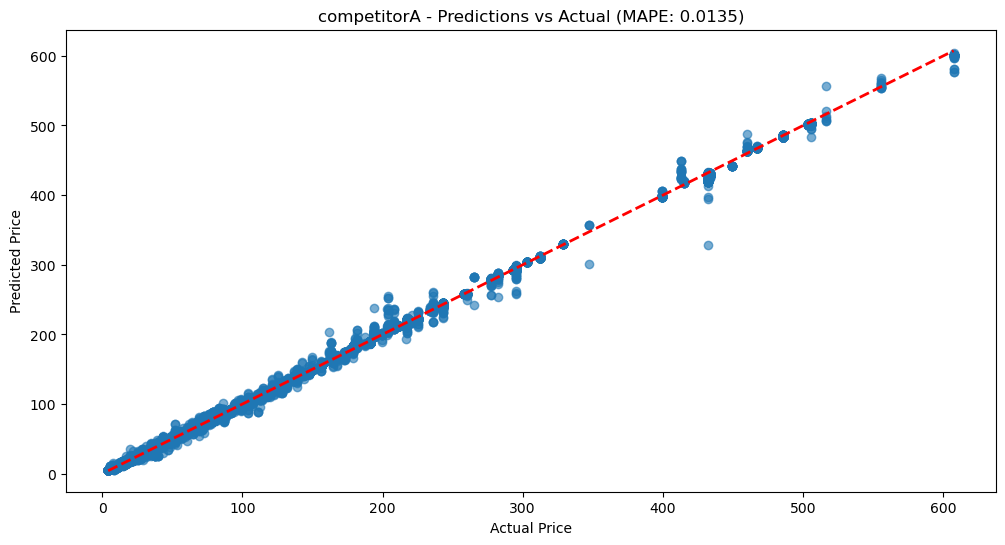


--- Evaluating competitorB ---
MAPE: 0.0108
RMSE: 3.3106
MAE: 0.5737


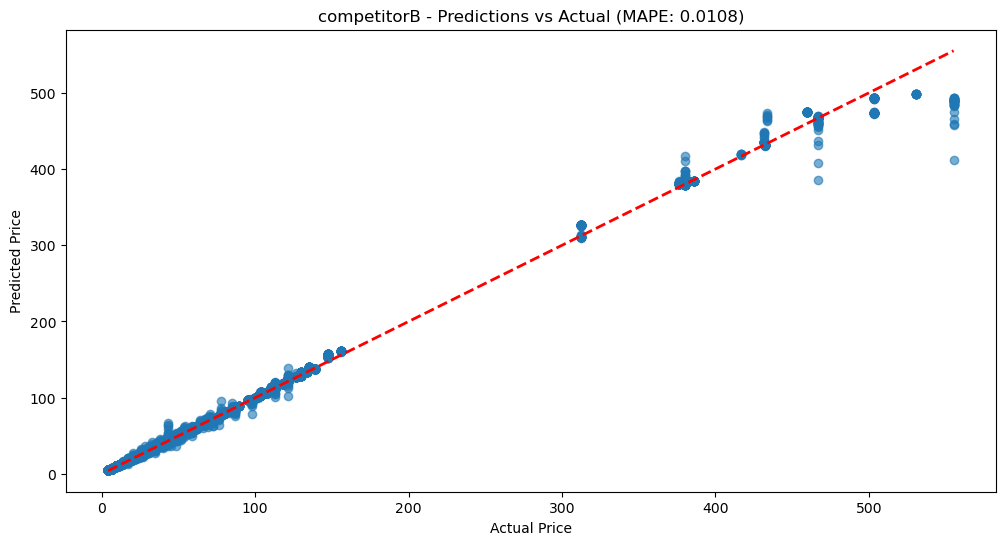

In [7]:
def evaluate_models(forecaster, modeling_df, feature_cols, test_dates):
    """Comprehensive model evaluation"""
    
    print("=== MODEL EVALUATION ===\n")
    
    results = {}
    
    for competitor in forecaster.target_competitors:
        if competitor not in forecaster.models:
            continue
        
        print(f"\n--- Evaluating {competitor} ---")
        
        # Prepare test data
        test_data = modeling_df[modeling_df['date'].isin(test_dates)]
        X_test, y_test, test_info = forecaster.prepare_data(test_data, feature_cols, competitor)
        
        if len(X_test) == 0:
            print(f"No test data for {competitor}")
            continue
        
        # Make predictions
        y_pred = forecaster.predict(X_test, competitor)
        
        # Calculate metrics
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = np.mean(np.abs(y_test - y_pred))
        
        results[competitor] = {
            'mape': mape,
            'rmse': rmse,
            'mae': mae,
            'predictions': y_pred,
            'actual': y_test.values,
            'test_info': test_info
        }
        
        print(f"MAPE: {mape:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        
        # Plot predictions vs actual
        plt.figure(figsize=(12, 6))
        plt.scatter(y_test, y_pred, alpha=0.6)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.xlabel('Actual Price')
        plt.ylabel('Predicted Price')
        plt.title(f'{competitor} - Predictions vs Actual (MAPE: {mape:.4f})')
        plt.show()
    
    return results

# Evaluate models
if 'forecaster' in locals():
    evaluation_results = evaluate_models(forecaster, modeling_df, feature_cols, test_dates)

# ================================
# CELL 8: Model Persistence and API Preparation
# ================================

In [8]:
# ================================
# CELL 8: Model Persistence and API Preparation (PostgreSQL Version)
# ================================
import os
import psycopg2
from psycopg2.extras import execute_values

# ---- CONFIGURE YOUR POSTGRES CONNECTION HERE ----
PG_DBNAME = "capsstone"
PG_USER = "postgres"
PG_PASSWORD = "1234"
PG_HOST = "localhost"
PG_PORT = 5432

def get_pg_conn():
    return psycopg2.connect(
        dbname=PG_DBNAME,
        user=PG_USER,
        password=PG_PASSWORD,
        host=PG_HOST,
        port=PG_PORT,
    )

def save_models_and_artifacts(forecaster, leaflet_encoder, feature_cols, target_competitors):
    """Save all models and necessary artifacts for API deployment"""
    print("=== SAVING MODELS AND ARTIFACTS ===\n")
    os.makedirs('saved_models', exist_ok=True)
    joblib.dump(forecaster, 'saved_models/competitor_price_forecaster.pkl')
    print("✅ Main forecaster saved")
    joblib.dump(leaflet_encoder, 'saved_models/leaflet_encoder.pkl')
    joblib.dump(feature_cols, 'saved_models/feature_columns.pkl')
    joblib.dump(target_competitors, 'saved_models/target_competitors.pkl')
    artifacts = {
        'feature_columns': feature_cols,
        'target_competitors': target_competitors,
        'model_version': '1.0',
        'created_date': datetime.now().isoformat()
    }
    joblib.dump(artifacts, 'saved_models/model_artifacts.pkl')
    print("✅ All artifacts saved successfully!")
    return artifacts

def create_database_schema():
    """Create PostgreSQL database schema for API"""
    print("=== CREATING DATABASE SCHEMA IN POSTGRESQL ===\n")
    with get_pg_conn() as conn:
        with conn.cursor() as cur:
            cur.execute('''
                CREATE TABLE IF NOT EXISTS forecasts (
                    id SERIAL PRIMARY KEY,
                    sku TEXT NOT NULL,
                    time_key INTEGER NOT NULL,
                    pvp_is_competitorA FLOAT,
                    pvp_is_competitorB FLOAT,
                    created_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                    UNIQUE(sku, time_key)
                )
            ''')
            cur.execute('''
                CREATE TABLE IF NOT EXISTS product_metadata (
                    sku TEXT PRIMARY KEY,
                    structure_level_1 INTEGER,
                    structure_level_2 INTEGER,
                    structure_level_3 INTEGER,
                    structure_level_4 INTEGER,
                    last_discount FLOAT DEFAULT 0.0,
                    last_flag_promo INTEGER DEFAULT 0,
                    last_leaflet TEXT,
                    updated_at TIMESTAMP DEFAULT CURRENT_TIMESTAMP
                )
            ''')
        conn.commit()
    print("✅ Database schema created successfully!")

def populate_product_metadata(modeling_df):
    """Populate product metadata table with latest product information (PostgreSQL version)"""
    print("=== POPULATING PRODUCT METADATA ===\n")
    latest_info = modeling_df.groupby('sku').last().reset_index()
    # Fill NaNs for all expected columns robustly
    fill_dict = {
        'structure_level_1': 0,
        'structure_level_2': 0,
        'structure_level_3': 0,
        'structure_level_4': 0,
        'discount': 0.0,
        'flag_promo': 0,
        'leaflet_encoded': 'none'
    }
    latest_info = latest_info.fillna(fill_dict)
    # If there are still NaNs, forcibly replace them (for any weird columns)
    latest_info = latest_info.replace({pd.NA: 0, None: 0})
    # Optionally: check for NaNs that weren't filled
    if latest_info.isnull().values.any():
        print("WARNING: NaNs still present after fillna. Filling all remaining NaNs with 0 or 'none'.")
        latest_info = latest_info.fillna(0)
    data_to_insert = []
    for _, row in latest_info.iterrows():
        data_to_insert.append((
            str(row['sku']),
            int(row['structure_level_1']),
            int(row['structure_level_2']),
            int(row['structure_level_3']),
            int(row['structure_level_4']),
            float(row['discount']),
            int(row['flag_promo']),
            str(row['leaflet_encoded'])
        ))
    with get_pg_conn() as conn:
        with conn.cursor() as cur:
            execute_values(
                cur,
                '''
                INSERT INTO product_metadata 
                (sku, structure_level_1, structure_level_2, structure_level_3, structure_level_4,
                 last_discount, last_flag_promo, last_leaflet)
                VALUES %s
                ON CONFLICT (sku) DO UPDATE SET
                    structure_level_1 = EXCLUDED.structure_level_1,
                    structure_level_2 = EXCLUDED.structure_level_2,
                    structure_level_3 = EXCLUDED.structure_level_3,
                    structure_level_4 = EXCLUDED.structure_level_4,
                    last_discount = EXCLUDED.last_discount,
                    last_flag_promo = EXCLUDED.last_flag_promo,
                    last_leaflet = EXCLUDED.last_leaflet,
                    updated_at = CURRENT_TIMESTAMP
                '''
                , data_to_insert
            )
        conn.commit()
    print(f"✅ Populated metadata for {len(latest_info)} products!")
    
# Save everything (PostgreSQL version)
if 'forecaster' in locals():
    saved_artifacts = save_models_and_artifacts(forecaster, leaflet_encoder, feature_cols, target_competitors)
    create_database_schema()
    populate_product_metadata(modeling_df)

=== SAVING MODELS AND ARTIFACTS ===

✅ Main forecaster saved
✅ All artifacts saved successfully!
=== CREATING DATABASE SCHEMA IN POSTGRESQL ===

✅ Database schema created successfully!
=== POPULATING PRODUCT METADATA ===

✅ Populated metadata for 2501 products!


# ================================
# CELL 9: API Helper Functions
# ================================

In [9]:
import joblib
import pandas as pd
from datetime import datetime
import psycopg2
from psycopg2.extras import execute_values

# ---- CONFIGURE YOUR POSTGRES CONNECTION HERE ----
PG_DBNAME = "capsstone"
PG_USER = "postgres"
PG_PASSWORD = "1234"
PG_HOST = "localhost"
PG_PORT = 5432


def get_pg_conn():
    return psycopg2.connect(
        dbname=PG_DBNAME,
        user=PG_USER,
        password=PG_PASSWORD,
        host=PG_HOST,
        port=PG_PORT,
    )

def load_forecasting_system():
    """Load the complete forecasting system for API use"""
    try:
        forecaster = joblib.load('saved_models/competitor_price_forecaster.pkl')
        leaflet_encoder = joblib.load('saved_models/leaflet_encoder.pkl')
        feature_cols = joblib.load('saved_models/feature_columns.pkl')
        target_competitors = joblib.load('saved_models/target_competitors.pkl')
        print("✅ Forecasting system loaded successfully!")
        return forecaster, leaflet_encoder, feature_cols, target_competitors
    except Exception as e:
        print(f"❌ Error loading forecasting system: {e}")
        return None, None, None, None

def get_product_metadata(sku):
    """Get product metadata from PostgreSQL database"""
    with get_pg_conn() as conn:
        with conn.cursor() as cursor:
            cursor.execute(
                '''
                SELECT * FROM product_metadata WHERE sku = %s
                ''', (str(sku),)
            )
            result = cursor.fetchone()
    if result:
        columns = [
            'sku', 'structure_level_1', 'structure_level_2', 'structure_level_3', 
            'structure_level_4', 'last_discount', 'last_flag_promo', 'last_leaflet', 'updated_at'
        ]
        return dict(zip(columns, result))
    return None

def prepare_api_features(sku, time_key, forecaster, leaflet_encoder, feature_cols):
    """Prepare features for API prediction"""
    # Get product metadata
    metadata = get_product_metadata(sku)
    if not metadata:
        # Use default values if metadata not found
        metadata = {
            'structure_level_1': 1,
            'structure_level_2': 101,
            'structure_level_3': 10101,
            'structure_level_4': 1010101,
            'last_discount': 0.0,
            'last_flag_promo': 0,
            'last_leaflet': 'none'
        }
    # Convert time_key to date features
    date_str = str(time_key)
    if len(date_str) == 8:
        date = datetime.strptime(date_str, '%Y%m%d')
    else:
        raise ValueError("Invalid time_key format. Expected YYYYMMDD")
    # Create feature vector
    features = {
        'sku': int(sku),
        'pvp_was': 20.0,  # Default price - in real API this should come from product catalog
        'discount': metadata['last_discount'],
        'flag_promo': metadata['last_flag_promo'],
        'leaflet_numeric': 0,  # Will be encoded
        'structure_level_1': metadata['structure_level_1'],
        'structure_level_2': metadata['structure_level_2'],
        'structure_level_3': metadata['structure_level_3'],
        'structure_level_4': metadata['structure_level_4'],
        'quantity': 100.0,  # Default quantity
        'year': date.year,
        'month': date.month,
        'day': date.day,
        'weekday': date.weekday(),
        'quarter': (date.month - 1) // 3 + 1,
        'week_of_year': date.isocalendar()[1],
        'is_campaign': 0  # Default no campaign
    }
    # Encode leaflet
    try:
        leaflet_encoded = leaflet_encoder.transform([metadata['last_leaflet']])[0]
        features['leaflet_numeric'] = leaflet_encoded
    except:
        features['leaflet_numeric'] = 0
    # Add default values for missing features
    for col in feature_cols:
        if col not in features:
            if 'lag_' in col or 'rolling_' in col or '_vs_' in col:
                features[col] = 0.0
            else:
                features[col] = 0
    # Create DataFrame with correct column order
    feature_df = pd.DataFrame([features])
    feature_df = feature_df.reindex(columns=feature_cols, fill_value=0)
    return feature_df

def make_forecast_prediction(sku, time_key):
    """Make prediction for API endpoint and store in PostgreSQL"""
    try:
        # Load system
        forecaster, leaflet_encoder, feature_cols, target_competitors = load_forecasting_system()
        if forecaster is None:
            return None, "Forecasting system not available"
        # Prepare features
        X = prepare_api_features(sku, time_key, forecaster, leaflet_encoder, feature_cols)
        # Make predictions
        predictions = forecaster.predict_all(X)
        # Format response
        response = {
            'sku': str(sku),
            'time_key': int(time_key),
            'pvp_is_competitorA': float(predictions.get('competitorA', [0.0])[0]) if 'competitorA' in predictions else 0.0,
            'pvp_is_competitorB': float(predictions.get('competitorB', [0.0])[0]) if 'competitorB' in predictions else 0.0
        }
        # Store in PostgreSQL (ensure unique constraint)
        with get_pg_conn() as conn:
            with conn.cursor() as cur:
                cur.execute(
                    '''
                    INSERT INTO forecasts (sku, time_key, pvp_is_competitorA, pvp_is_competitorB)
                    VALUES (%s, %s, %s, %s)
                    ON CONFLICT (sku, time_key) DO UPDATE
                    SET pvp_is_competitorA = EXCLUDED.pvp_is_competitorA,
                        pvp_is_competitorB = EXCLUDED.pvp_is_competitorB,
                        created_at = CURRENT_TIMESTAMP
                    ''',
                    (
                        response['sku'],
                        response['time_key'],
                        response['pvp_is_competitorA'],
                        response['pvp_is_competitorB']
                    )
                )
                conn.commit()
        return response, None
    except Exception as e:
        return None, f"Error in prediction: {e}"

# Example usage:
if __name__ == "__main__":
    # Example for a random sku and time_key
    example_sku = 2056
    example_time_key = 20241115  # YYYYMMDD
    prediction, error = make_forecast_prediction(example_sku, example_time_key)
    if error:
        print("Error:", error)
    else:
        print("Prediction:", prediction)

✅ Forecasting system loaded successfully!
Error: Error in prediction: column "pvp_is_competitora" of relation "forecasts" does not exist
LINE 2: ...            INSERT INTO forecasts (sku, time_key, pvp_is_com...
                                                             ^



# ================================
# CELL 10: API Handler Example (FastAPI style stub)
# ================================

In [10]:
"""
from fastapi import FastAPI, HTTPException, Request
from pydantic import BaseModel

app = FastAPI()

class ForecastRequest(BaseModel):
    sku: str
    time_key: int

@app.post('/forecast_prices/')
def forecast_prices_endpoint(req: ForecastRequest):
    try:
        if not (isinstance(req.sku, str) and isinstance(req.time_key, int)):
            raise HTTPException(status_code=422, detail='Invalid input format.')
        res, err = make_forecast_prediction(req.sku, req.time_key)
        if err:
            raise HTTPException(status_code=500, detail=err)
        return res
    except Exception as exc:
        raise HTTPException(status_code=422, detail=str(exc))
"""

"\nfrom fastapi import FastAPI, HTTPException, Request\nfrom pydantic import BaseModel\n\napp = FastAPI()\n\nclass ForecastRequest(BaseModel):\n    sku: str\n    time_key: int\n\n@app.post('/forecast_prices/')\ndef forecast_prices_endpoint(req: ForecastRequest):\n    try:\n        if not (isinstance(req.sku, str) and isinstance(req.time_key, int)):\n            raise HTTPException(status_code=422, detail='Invalid input format.')\n        res, err = make_forecast_prediction(req.sku, req.time_key)\n        if err:\n            raise HTTPException(status_code=500, detail=err)\n        return res\n    except Exception as exc:\n        raise HTTPException(status_code=422, detail=str(exc))\n"

In [11]:
print(modeling_df.columns.tolist())

['sku', 'time_key', 'competitor', 'pvp_was', 'discount', 'flag_promo', 'leaflet', 'date', 'final_price', 'structure_level_1', 'structure_level_2', 'structure_level_3', 'structure_level_4', 'quantity', 'year', 'month', 'day', 'weekday', 'quarter', 'week_of_year', 'price_lag_1', 'discount_lag_1', 'price_lag_7', 'discount_lag_7', 'price_lag_14', 'discount_lag_14', 'price_lag_30', 'discount_lag_30', 'price_rolling_mean_7', 'price_rolling_std_7', 'price_rolling_mean_14', 'price_rolling_std_14', 'price_rolling_mean_30', 'price_rolling_std_30', 'is_campaign', 'chain_vs_competitorA_diff', 'chain_vs_competitorA_ratio', 'chain_vs_competitorB_diff', 'chain_vs_competitorB_ratio', 'competitorA_vs_competitorB_diff', 'competitorA_vs_competitorB_ratio', 'leaflet_encoded', 'leaflet_numeric']


Fill forecats

In [19]:
PG_DBNAME = "capsstone"
PG_USER = "postgres"
PG_PASSWORD = "1234"
PG_HOST = "localhost"
PG_PORT = 5432

def get_pg_conn():
    return psycopg2.connect(
        dbname=PG_DBNAME,
        user=PG_USER,
        password=PG_PASSWORD,
        host=PG_HOST,
        port=PG_PORT,
    )

# --- Check columns of forecasts table in PostgreSQL ---
with get_pg_conn() as conn:
    with conn.cursor() as cur:
        cur.execute("""
            SELECT column_name, data_type
            FROM information_schema.columns
            WHERE table_name = 'forecasts'
            ORDER BY ordinal_position
        """)
        columns = cur.fetchall()
        print("Columns in forecasts table:")
        for col, dtype in columns:
            print(f"  {col} ({dtype})")

# --- ASSUMES modeling_df IS ALREADY LOADED ---

# 1. Pivot to wide format: one row per sku/time_key, columns for each competitor's price
pivot_df = modeling_df.pivot_table(
    index=['sku', 'time_key'],
    columns='competitor',
    values='final_price'
).reset_index()

# 2. Flatten columns if MultiIndex (from pivot_table)
if isinstance(pivot_df.columns, pd.MultiIndex):
    pivot_df.columns = [
        '_'.join([str(i) for i in col if i and i != '-']) for col in pivot_df.columns.values
    ]

# 3. Rename columns to match forecasts table
pivot_df = pivot_df.rename(
    columns={
        'A': 'pvp_is_competitorA',
        'B': 'pvp_is_competitorB',
        'final_price_A': 'pvp_is_competitorA',
        'final_price_B': 'pvp_is_competitorB'
    }
)

# 4. Ensure data types match your PostgreSQL schema
pivot_df['sku'] = pivot_df['sku'].astype(str)
pivot_df['time_key'] = pivot_df['time_key'].astype(int)

if 'pvp_is_competitorA' not in pivot_df.columns:
    pivot_df['pvp_is_competitorA'] = 0.0
if 'pvp_is_competitorB' not in pivot_df.columns:
    pivot_df['pvp_is_competitorB'] = 0.0

pivot_df['pvp_is_competitorA'] = pivot_df['pvp_is_competitorA'].astype(float).fillna(0.0)
pivot_df['pvp_is_competitorB'] = pivot_df['pvp_is_competitorB'].astype(float).fillna(0.0)

# 5. Prepare records for batch insert
records = list(
    pivot_df[['sku', 'time_key', 'pvp_is_competitorA', 'pvp_is_competitorB']].itertuples(index=False, name=None)
)

# 6. Bulk Insert Into PostgreSQL (QUOTED identifiers!)
insert_query = """
    INSERT INTO forecasts (sku, time_key, "pvp_is_competitorA", "pvp_is_competitorB")
    VALUES %s
    ON CONFLICT (sku, time_key) DO UPDATE
    SET "pvp_is_competitorA" = EXCLUDED."pvp_is_competitorA",
        "pvp_is_competitorB" = EXCLUDED."pvp_is_competitorB"
"""

with get_pg_conn() as conn:
    with conn.cursor() as cur:
        execute_values(cur, insert_query, records)
    conn.commit()

print(f"✅ Inserted/updated {len(records)} forecast rows into PostgreSQL.")

Columns in forecasts table:
  id (integer)
  sku (text)
  time_key (integer)
  pvp_is_competitorA (double precision)
  pvp_is_competitorB (double precision)
  created_at (timestamp without time zone)
  pvp_is_competitorA_actual (double precision)
  pvp_is_competitorB_actual (double precision)
✅ Inserted/updated 1137011 forecast rows into PostgreSQL.
